In [1]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm
from torchvision.utils import make_grid

from torch.optim import Adam
import math

from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

plt.rc('font', size=30)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
mnist_train =MNIST('mnist',train=True, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 96145262.41it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44798703.34it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27068703.75it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21357095.03it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [3]:
mnist_train[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [4]:
mnist_train[0][0]

In [5]:
mnist_train =MNIST('mnist',
                   train=True, 
                   download=True, 
                   transform=T.ToTensor()
                  )

In [6]:
mnist_valid =MNIST('mnist',
                   train= False, 
                   download=True, 
                   transform=T.ToTensor()
                  )

In [7]:
len(mnist_train)

60000

In [8]:
len(mnist_valid)

10000

In [9]:
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
valid_loader = DataLoader(mnist_valid, batch_size=64, shuffle=False)

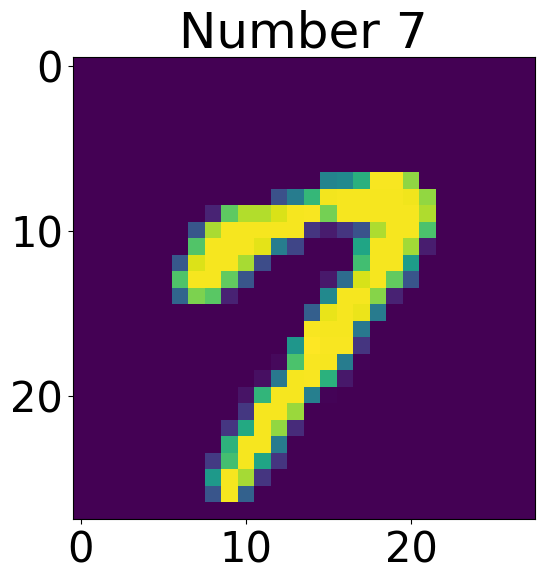

In [10]:
plt.figure(figsize=(6, 6))
plt.title(f'Number {mnist_train[15][1]}')
plt.imshow(mnist_train[15][0][0])

plt.show()

Let's train a fully connected neural network on the MNIST dataset

In [11]:
def train(model: nn.Module) -> float: #return the average loss during training
    model.train() #switch to training mode
    train_loss = 0

    for x, y in tqdm(train_loader, desc='Train'):
        optimizer.zero_grad()
        output = model(x) #forward pass
        loss = loss_fn(output, y)
        train_loss += loss.item()
        loss.backward() #backward pass
        optimizer.step() #optimisation step

    train_loss /= len(train_loader) #avg loss
    
    return train_loss

**Quality assessment function**

In [12]:
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader) -> tuple[float, float]: 
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        output = model(x) #forward pass
        loss = loss_fn(output, y)
        total_loss += loss.item()
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [13]:
#graphs
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(valid_accuracy)
    plt.grid()

    plt.show()

In [14]:
first_model = nn.Sequential(
    nn.Flatten(), #pull it into a vector
    nn.Linear(28 * 28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

optimizer = torch.optim.Adam(first_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

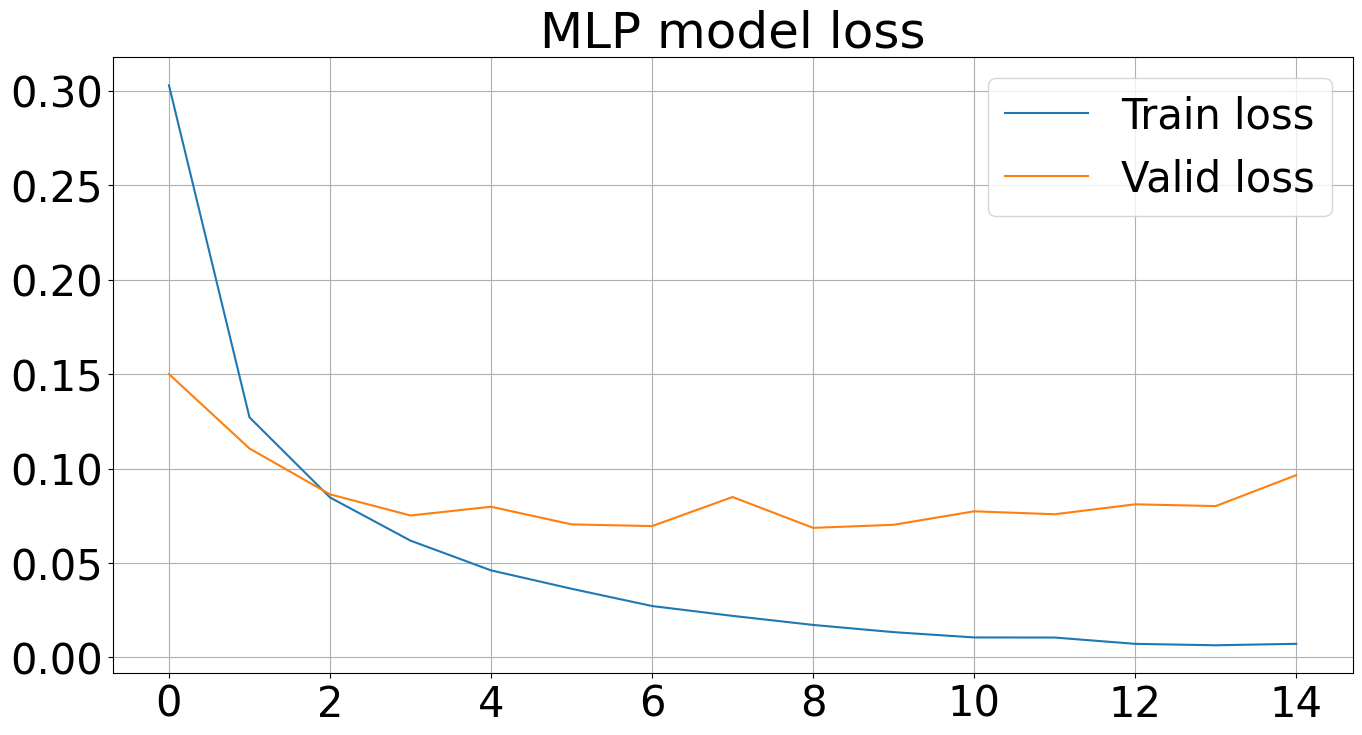

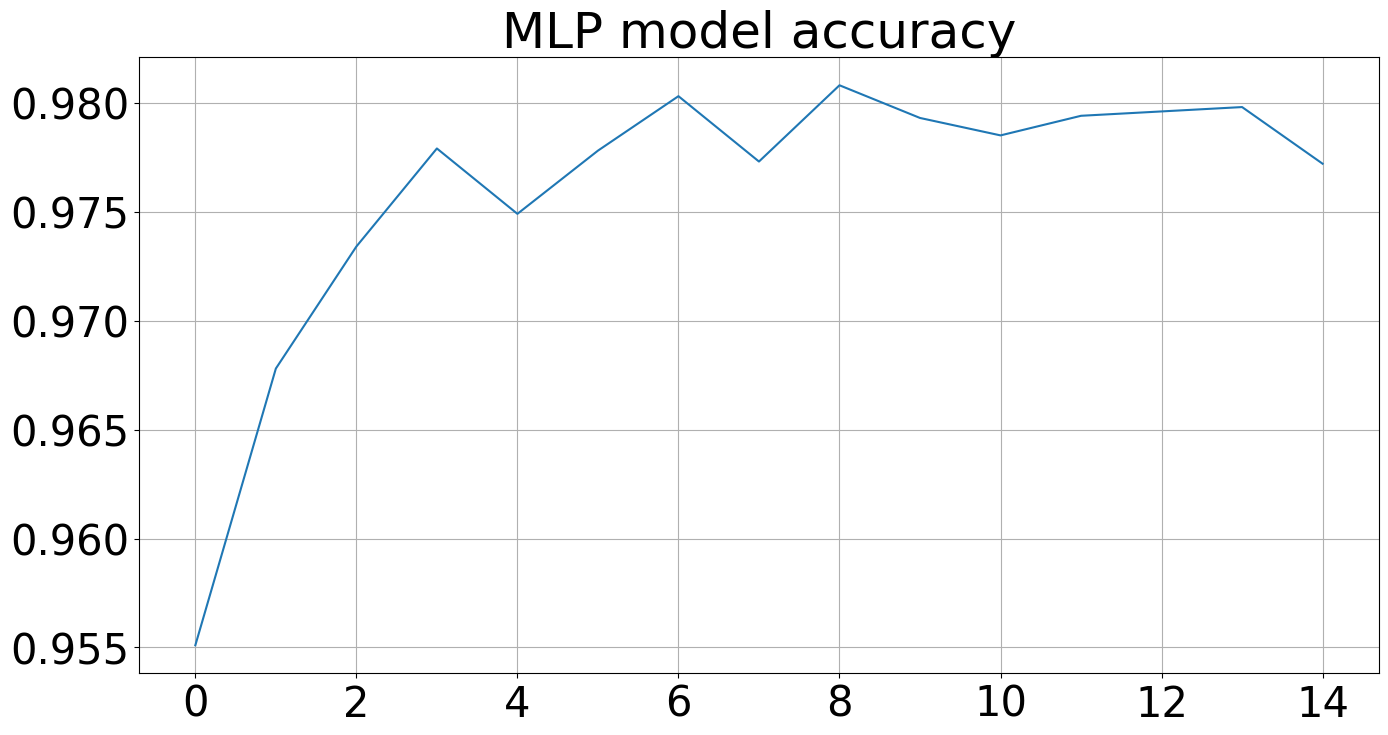

Total training and evaluation time 163.46284


In [15]:
num_epochs = 15

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(first_model)

    valid_loss, valid_accuracy = evaluate(first_model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)
    
    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'MLP model')
    
print(f'Total training and evaluation time {perf_counter() - start:.5f}')

**Convolutional network**

In [16]:
second_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5), #28*28*1-->24*24*32
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),#24*24*32-->12*12*32

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),#12*12*32-->8*8*64
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),#8*8*64-->4*4*64

    nn.Flatten(),
    nn.Linear(4 * 4 * 64, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

optimizer = torch.optim.Adam(second_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

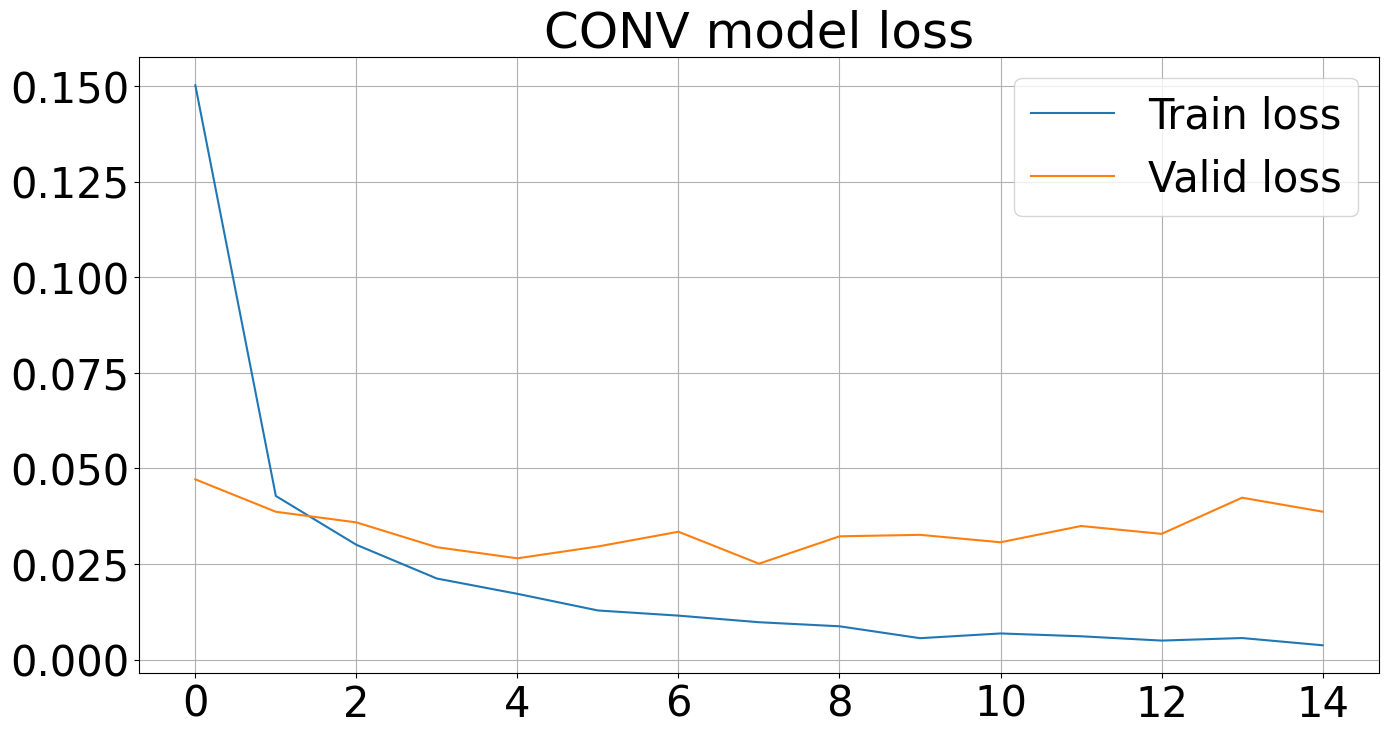

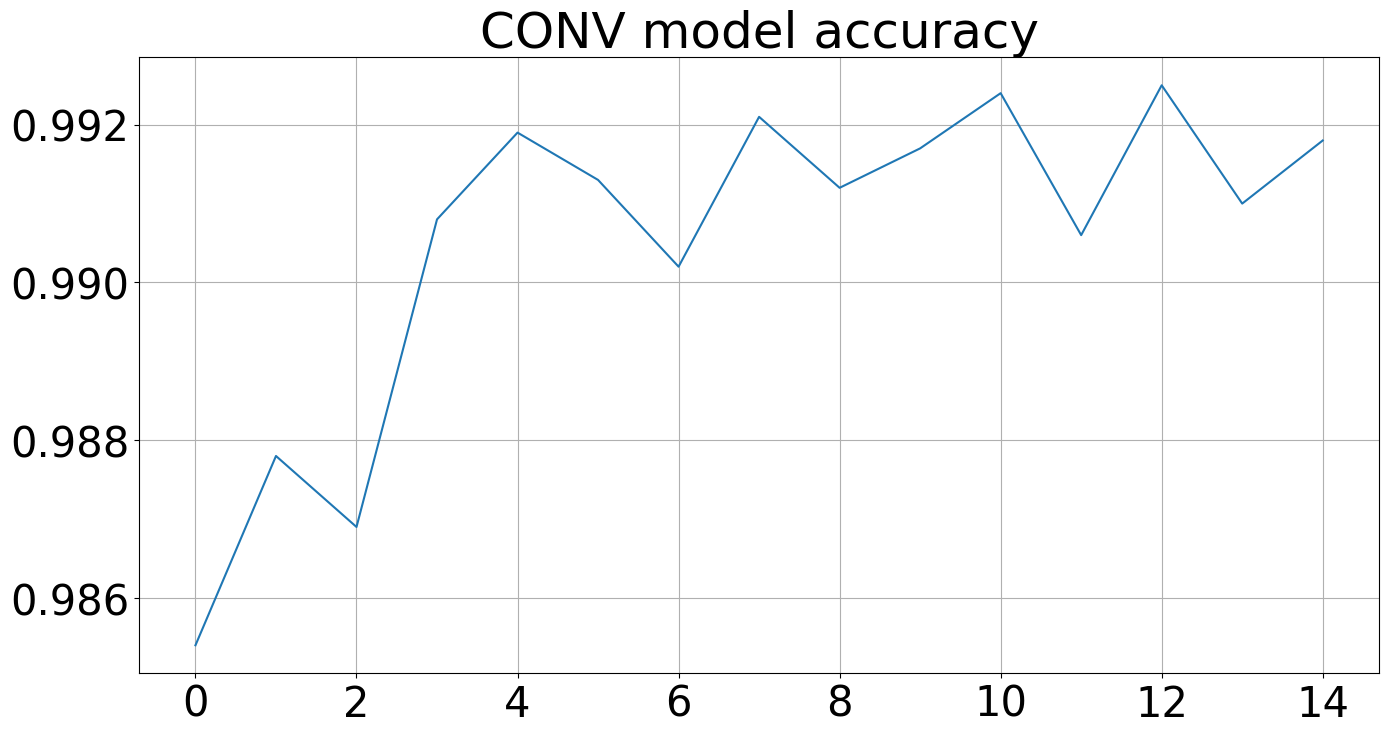

Total training and evaluation time 415.11060


In [17]:
num_epochs = 15

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(second_model)

    valid_loss, valid_accuracy = evaluate(second_model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'CONV model')

print(f'Total training and evaluation time {perf_counter() - start:.5f}')

**Normalization of input data**

A good practice in deep learning is to normalize the input data.

In [18]:
mean = mnist_train.data.to(torch.float32).mean().item() / 255

mean

0.13066047219669116

In [19]:
std = mnist_train.data.to(torch.float32).std().item() / 255

std

0.30810780244715075

In [20]:
normalize = T.Normalize(mean=(mean), std=(std))

In [21]:
mnist_train[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [22]:
normalized_image = normalize(mnist_train[0][0])

In [23]:
normalized_image

tensor([[[-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0

In [24]:
normalized_image.mean()

tensor(0.0228)

In [25]:
normalized_image.std()

tensor(1.0144)

In [26]:
normalize(mnist_train.data.to(torch.float32) / 255).mean()

tensor(2.9397e-08)

In [27]:
normalize(mnist_train.data.to(torch.float32) / 255).std()

tensor(1.0000)

Autoencoders

In [28]:
mnist_transforms = T.Compose(
    [
        T.Resize((64, 64)),
        T.ToTensor(),
    ]
)

train_dataset = MNIST('mnist', train=True, transform=mnist_transforms, download=True)
valid_dataset = MNIST('mnist', train=False, transform=mnist_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

In [29]:
def train(model):
    model.train()
    train_loss = 0

    for x, _ in tqdm(train_loader, desc='Train'):
        x = x.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, x)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    return train_loss

In [30]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()
    total_loss = 0

    for x, _ in tqdm(loader, desc='Evaluation'):
        x = x.to(device)
        output = model(x)
        loss = loss_fn(output, x)
        total_loss += loss.item()

    total_loss /= len(loader)

    return total_loss

In [31]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))
    plt.title(title + ' loss')
    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

In [32]:
@torch.inference_mode()
def visualize(model, xs): #displaying model predictions
    model.eval()
    to_pil = T.ToPILImage()
    outputs = model(xs.to(device)).cpu()
    plt.figure(figsize=(20, 4))
    plt.imshow(
        to_pil(
            torch.cat((
                make_grid(xs[:10], nrow=10, pad_value=1),
                make_grid(outputs[:10], nrow=10, pad_value=1)),dim=1)
        ))
    
    plt.axis('off')

    plt.show()

In [33]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss = train(model)
        valid_loss = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        clear_output(wait=True)
        
        visualize(model, next(iter(valid_loader))[0])

        plot_stats(
            train_loss_history, valid_loss_history,
            title
        )

In [34]:
class Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, upsample: bool = False):
        super().__init__()
        self.upsample = upsample

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=1,
            bias=False
        )
        self.norm = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)

        return self.act(self.norm(self.conv(x)))


class AutoEncoder(nn.Module):
    def __init__(self, in_channels: int, base_block: nn.Module = Block, base_size: int = 32, num_blocks: int = 4):
        super().__init__()

        self.base_size = base_size

        # encoder creation
        encoder_blocks = []

        for i in range(num_blocks):
            encoder_blocks.append(
                base_block(
                    in_channels=base_size if i else in_channels,
                    out_channels=base_size,
                    kernel_size=3,
                    stride=2 
                )
            )

        encoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=base_size,
                kernel_size=3
            ).conv
        )

        self.encoder = nn.Sequential(*encoder_blocks)  # N -> N // (2 ** num_blocks)

        # decoder creation
        decoder_blocks = []

        for i in range(num_blocks):
            decoder_blocks.append(
                base_block(
                    in_channels=base_size,
                    out_channels=base_size,
                    kernel_size=3,
                    upsample=True
                )
            )

        decoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=in_channels,
                kernel_size=3
            ).conv
        )
        decoder_blocks.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_blocks)  # N // (2 ** num_blocks) -> N

        self.flatten = nn.Flatten()

    def forward(self, x):
        # x.shape = [bs, in_channels, N, N]
        x = self.encoder(x)
        # x.shape = [bs, base_size, N // (2 ** num_blocks), N // (2 ** num_blocks)]
        x = self.decoder(x)
        # x.shape = [bs, in_channels, N, N]

        return x

    @torch.inference_mode()
    def encode(self, x): #image to vector
        # x.shape = [bs, in_channels, N, N]
        return self.flatten(self.encoder(x)) # output.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2]

    @torch.inference_mode()
    def decode(self, x): #vector to image 
        # x.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2]
        latent_size = int(math.sqrt(x.shape[1] // self.base_size))

        return self.decoder(x.view(-1, self.base_size, latent_size, latent_size))  # output.shape = [bs, in_channels, N, N]

In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.MSELoss() #pixel-by-pixel comparison with the original image

cuda:0
Tesla T4


In [36]:
model = AutoEncoder(in_channels=1).to(device)

optimizer = Adam(model.parameters(), lr=1e-3) 

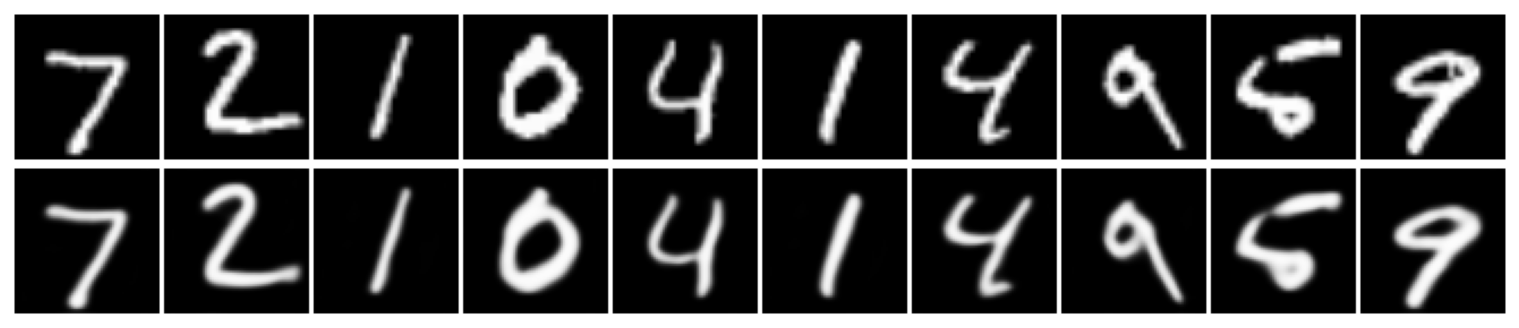

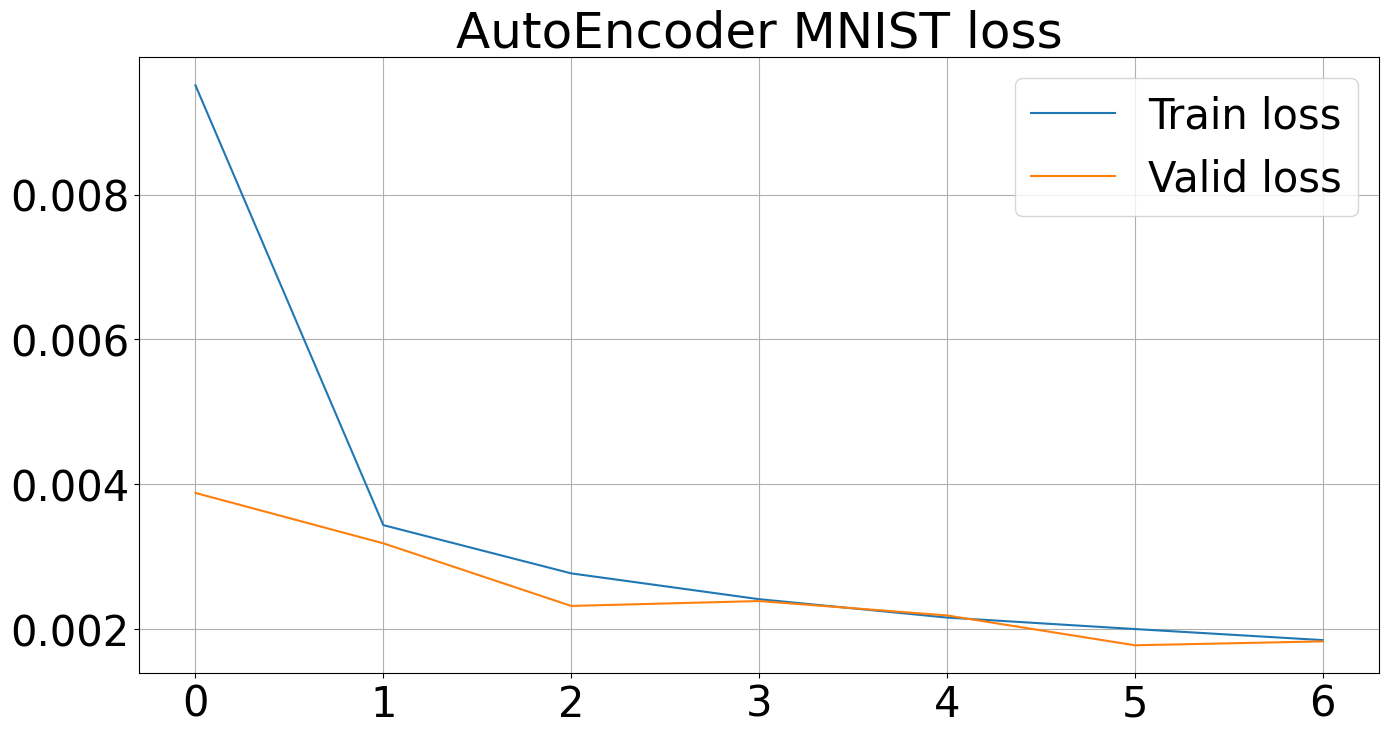

In [37]:
whole_train_valid_cycle(model, 7, 'AutoEncoder MNIST')

In [38]:
@torch.inference_mode()
def get_interpolation(model, x1, x2):
    z1 = model.encode(x1.unsqueeze(0).to(device))
    z2 = model.encode(x2.unsqueeze(0).to(device))
    weights = torch.linspace(start=0, end=1, steps=7).unsqueeze(1).to(device)
    zs = z2 * weights + z1 * (1 - weights)
    images = model.decode(zs)
    
    plt.figure(figsize=(14, 4))
    plt.imshow(T.ToPILImage()(make_grid(images, nrow=7, pad_value=1)))
    plt.axis('off')
    plt.show()

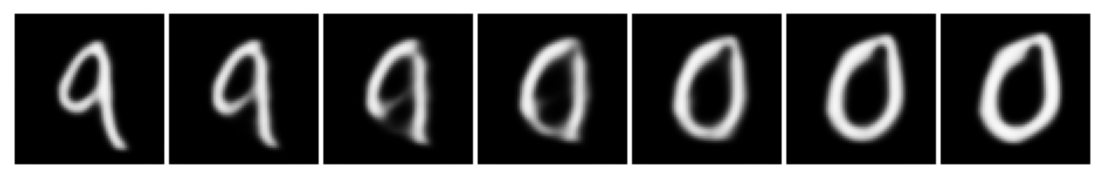

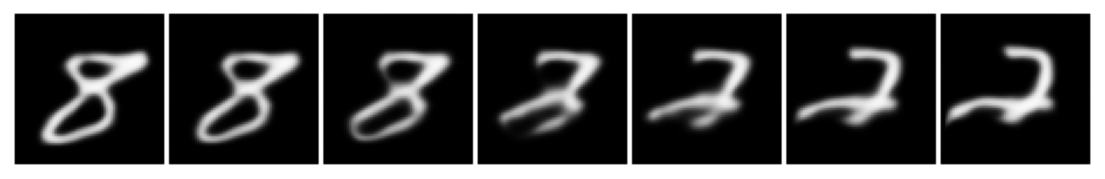

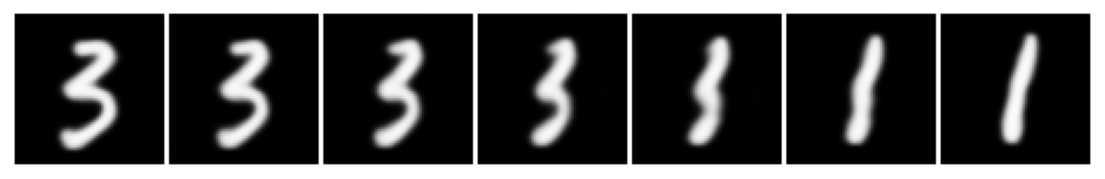

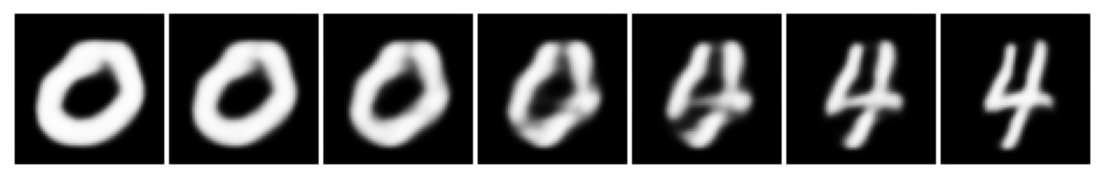

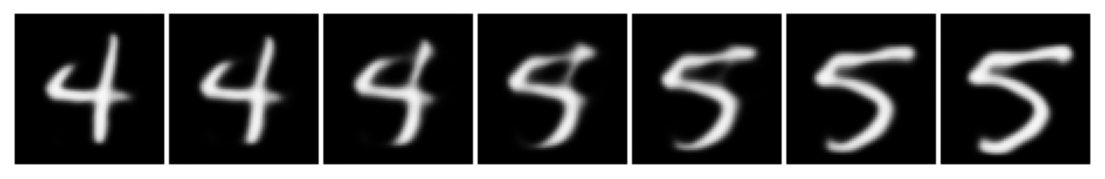

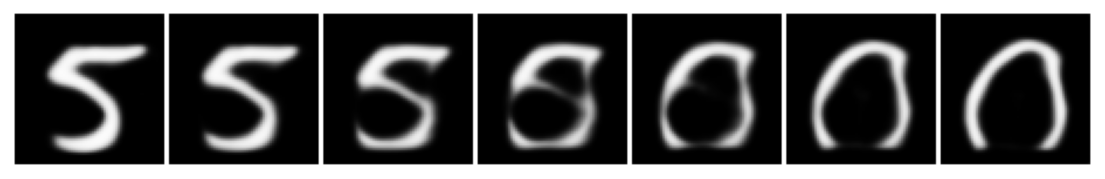

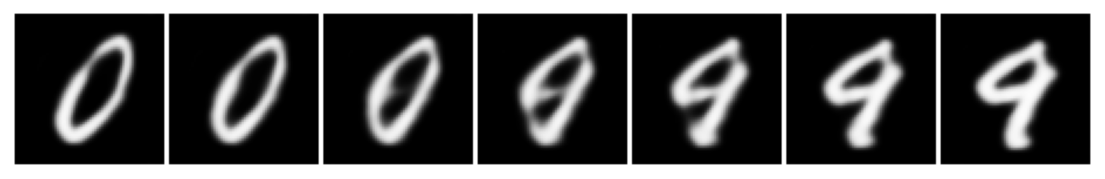

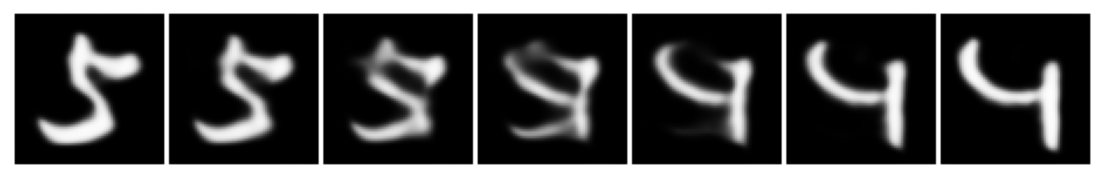

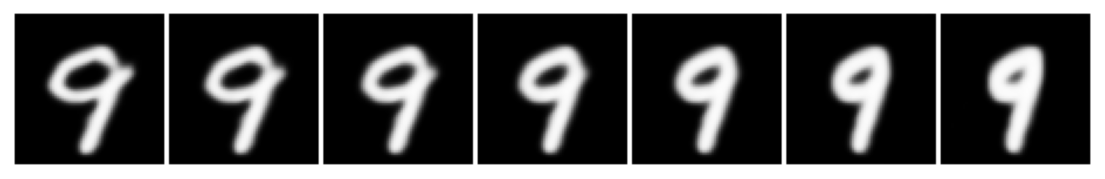

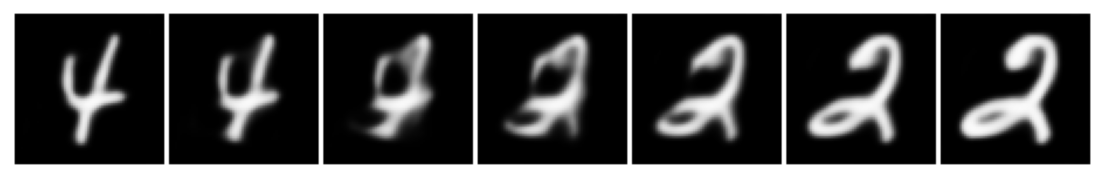

In [39]:
for _ in range(10):
    idx1, idx2 = np.random.randint(len(valid_dataset), size=2)
    get_interpolation(model, valid_dataset[idx1][0], valid_dataset[idx2][0])

In [40]:
class DenoisingBlock(Block):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, upsample: bool = False):
        super().__init__(in_channels, out_channels, kernel_size, stride, upsample)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)

        if self.training:
            x = x + torch.randn_like(x) * 0.05

        return self.act(self.norm(self.conv(x)))


class DenoisingAutoEncoder(AutoEncoder):
    def __init__(self, in_channels: int, base_block: nn.Module = DenoisingBlock, base_size: int = 32, num_blocks: int = 4):
        super().__init__(in_channels, base_block, base_size, num_blocks)

    def forward(self, x):
        if self.training:
            x = torch.clip(x + torch.randn_like(x) * 0.1, min=0, max=1) #add noise,but keep[0,1]

        # x.shape = [bs, in_channels, N, N]
        x = self.encoder(x)
        # x.shape = [bs, base_size, N // (2 ** num_blocks), N // (2 ** num_blocks)]
        x = self.decoder(x)
        # x.shape = [bs, in_channels, N, N]

        return x

In [41]:
de_model = DenoisingAutoEncoder(in_channels=1).to(device)

optimizer = Adam(de_model.parameters(), lr=1e-3)

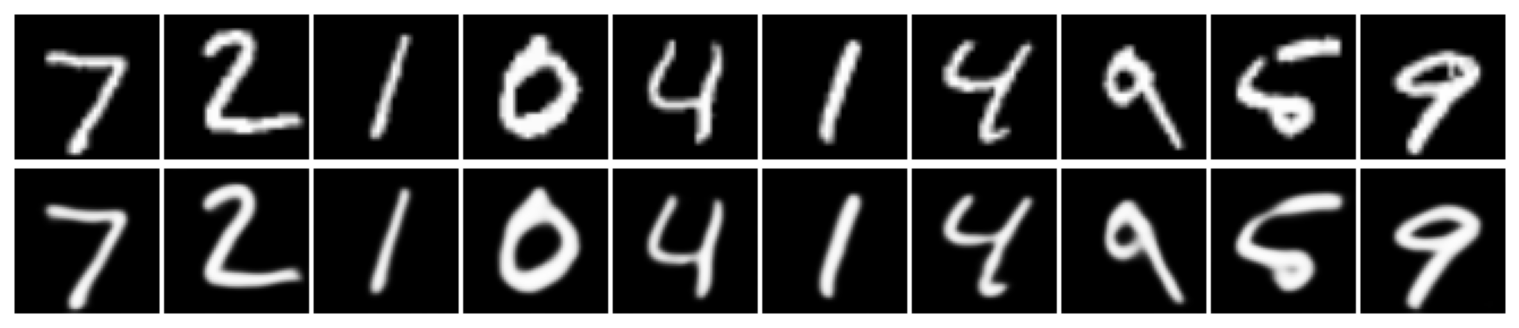

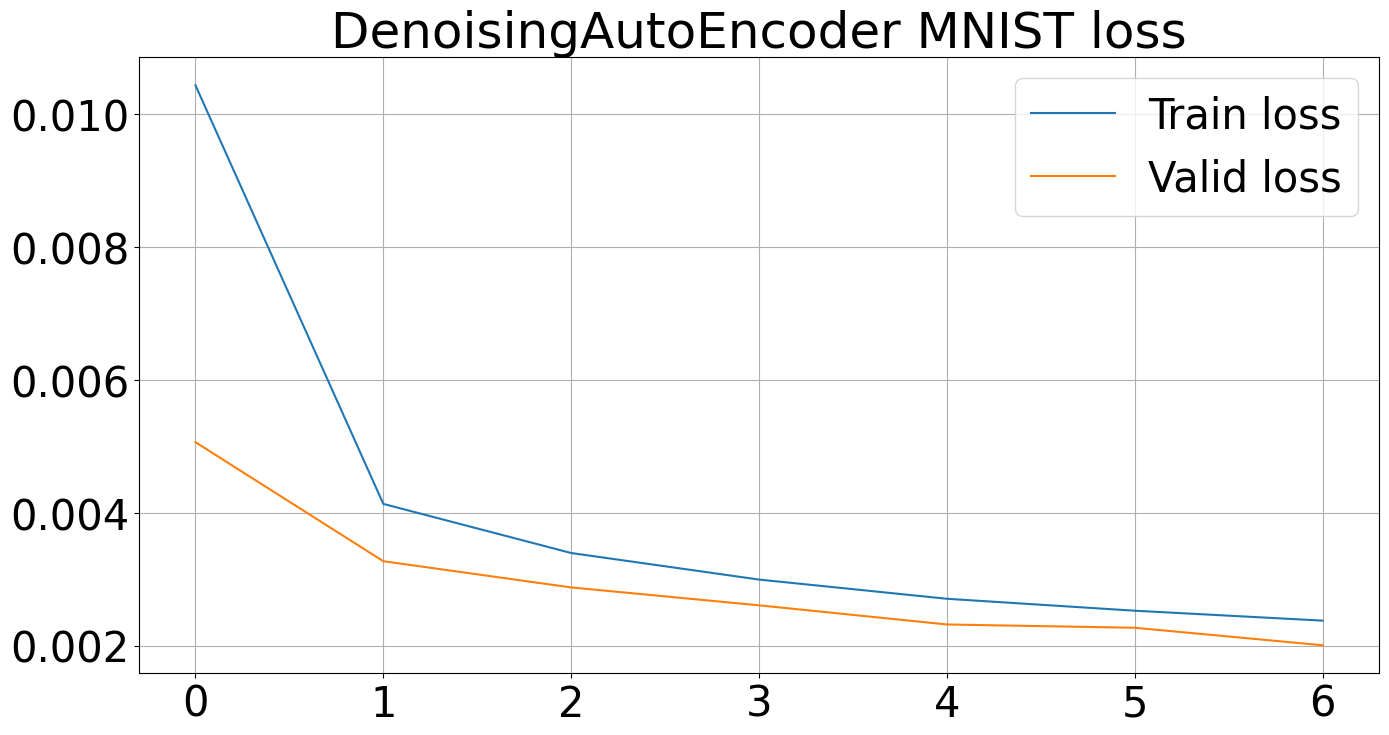

In [42]:
whole_train_valid_cycle(de_model, 7, 'DenoisingAutoEncoder MNIST')

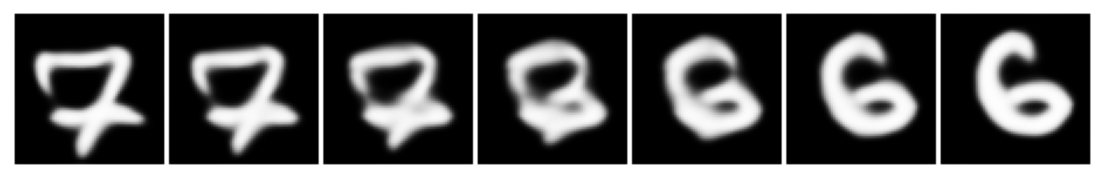

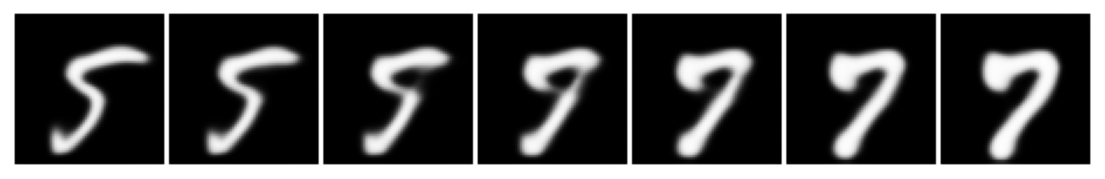

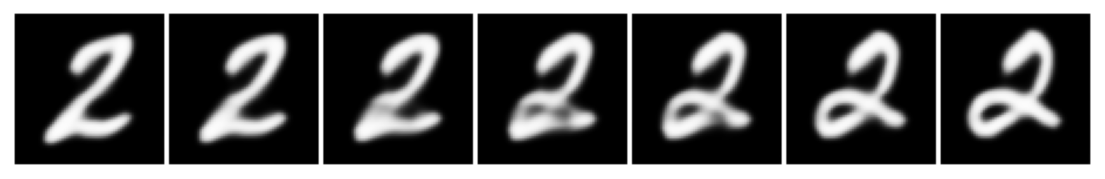

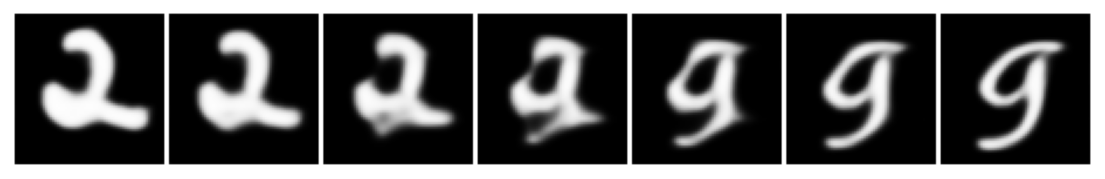

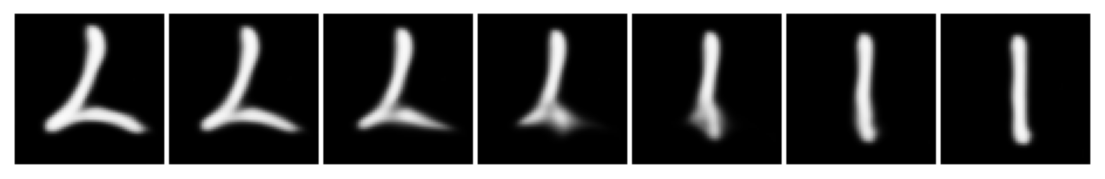

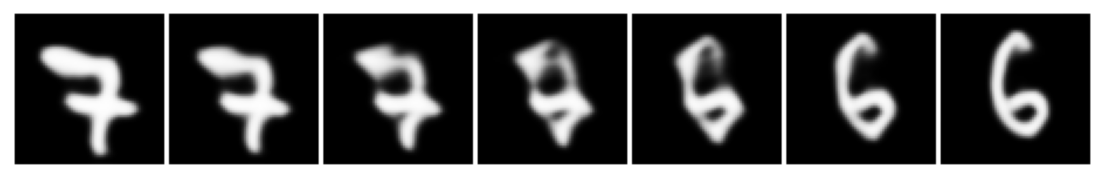

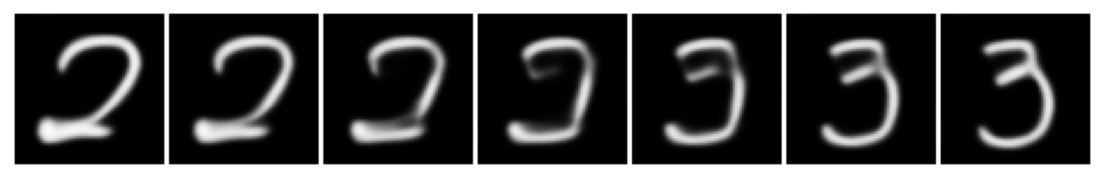

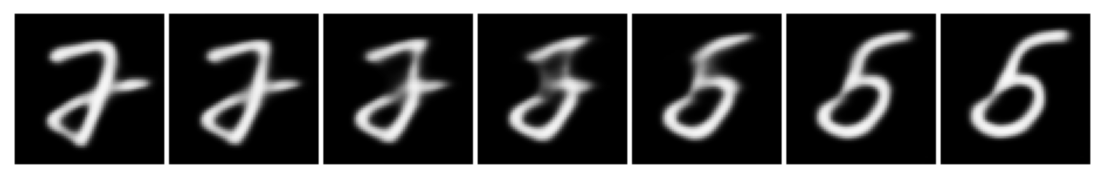

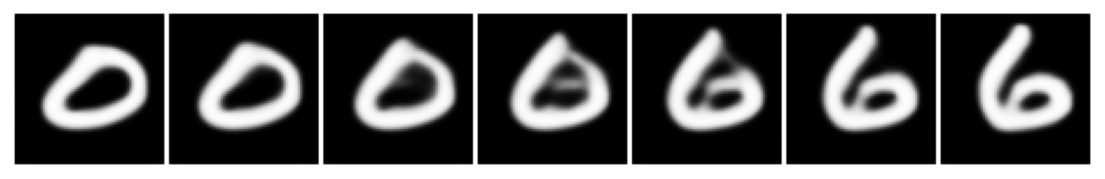

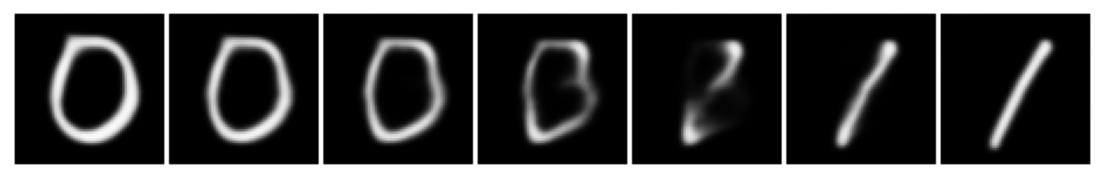

In [43]:
for _ in range(10):
    idx1, idx2 = np.random.randint(len(valid_dataset), size=2)
    get_interpolation(de_model, valid_dataset[idx1][0], valid_dataset[idx2][0])

In [44]:
class AddNoise:
    def __init__(self, noise_level: float = 0.1):
        self.noise_level = noise_level

    def __call__(self, x):
        return torch.clip(x + torch.randn_like(x) * self.noise_level, min=0, max=1)


class FlipRandomBits:
    def __init__(self, flip_ratio=0.1):
        self.flip_ratio = flip_ratio

    def __call__(self, x):
        mask = torch.rand_like(x) < self.flip_ratio

        x[mask] = 1 - x[mask]

        return x


def test_denoising(model):
    transforms = [AddNoise(), AddNoise(noise_level=0.25), FlipRandomBits()]

    for transform in transforms:
        print('-' * 100)

        for i, batch in enumerate(valid_loader):
            visualize(model, transform(batch[0]))

            if i == 1:
                break

----------------------------------------------------------------------------------------------------


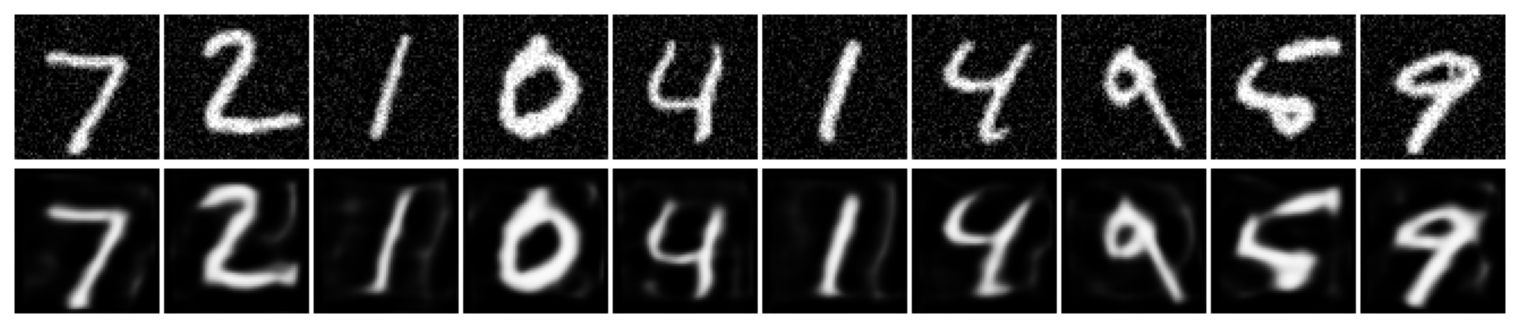

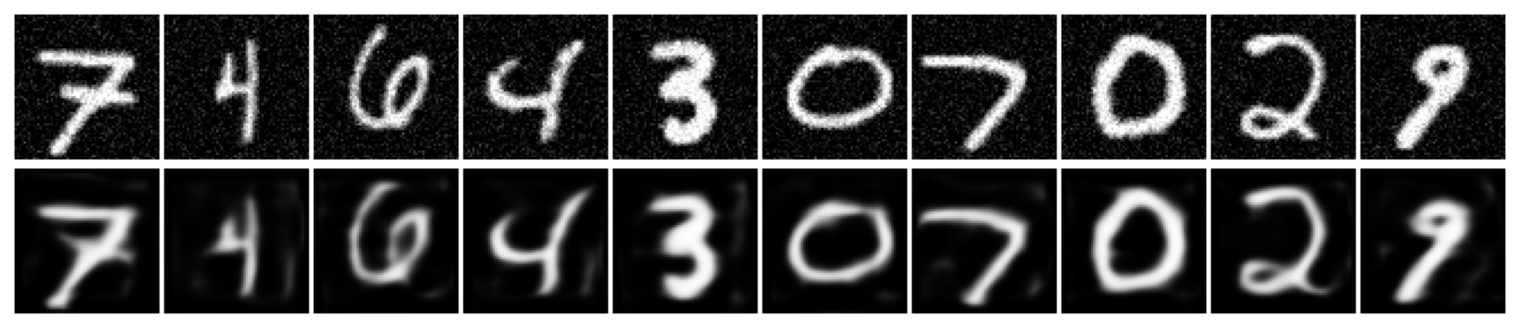

----------------------------------------------------------------------------------------------------


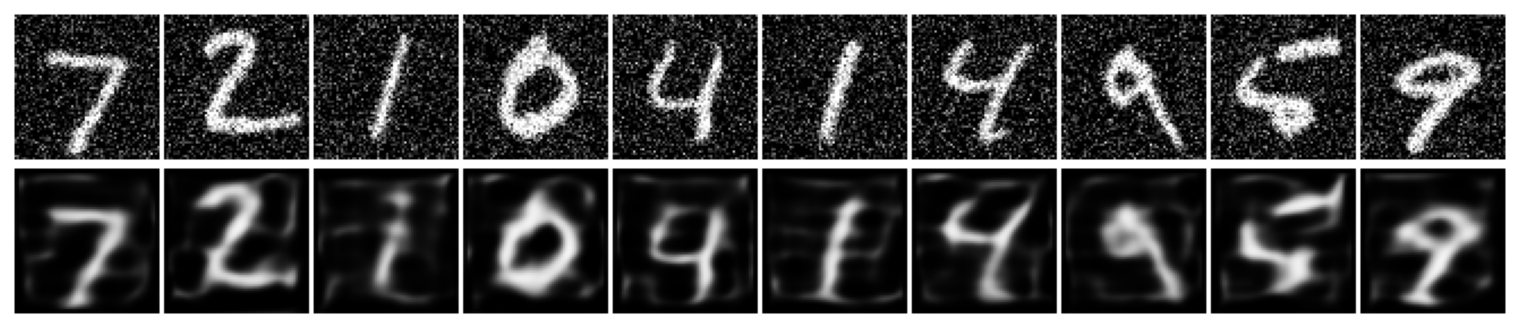

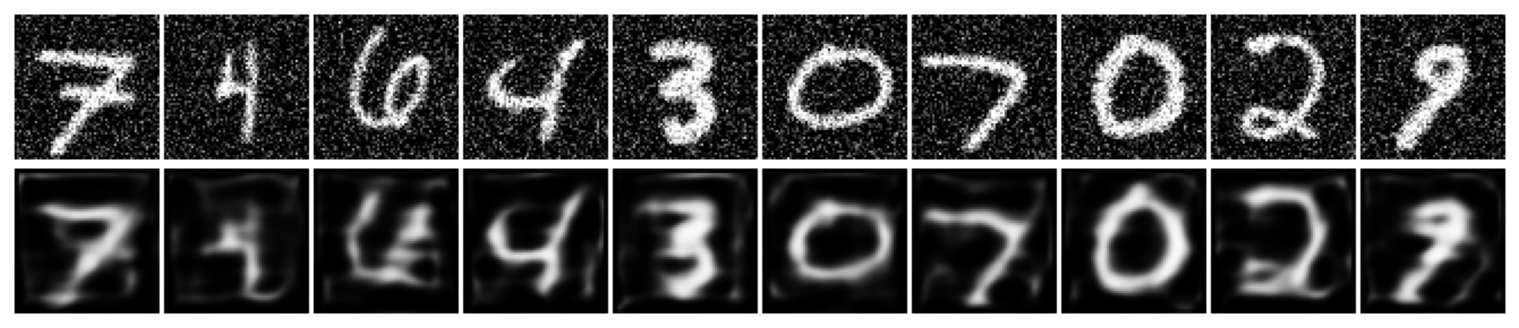

----------------------------------------------------------------------------------------------------


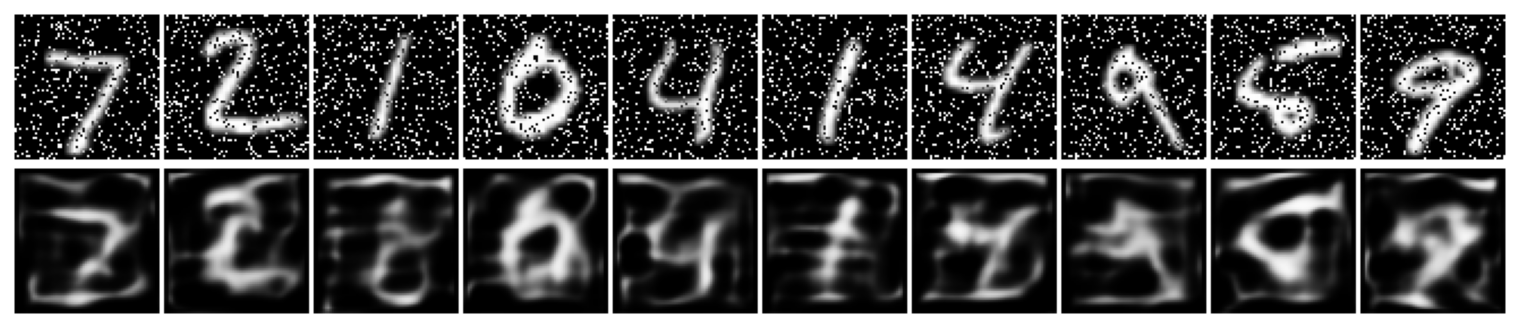

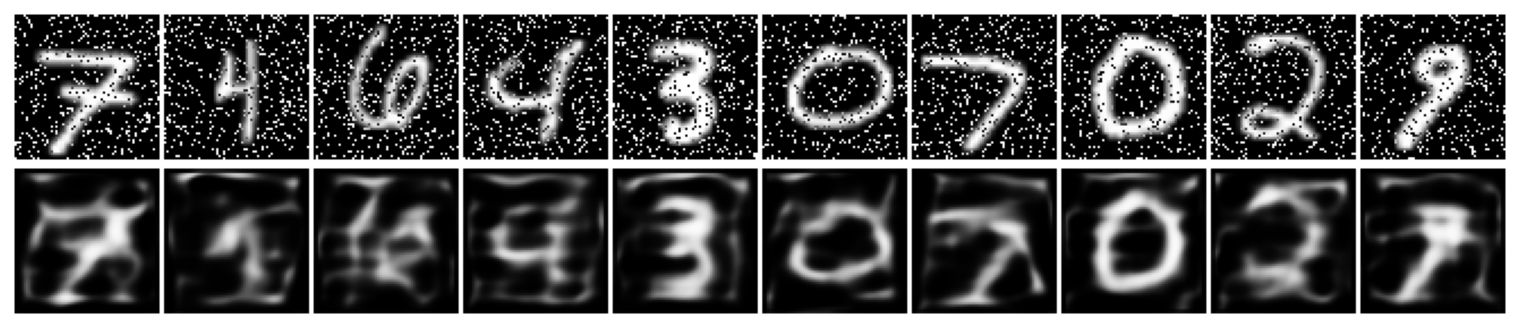

In [45]:
test_denoising(model)

----------------------------------------------------------------------------------------------------


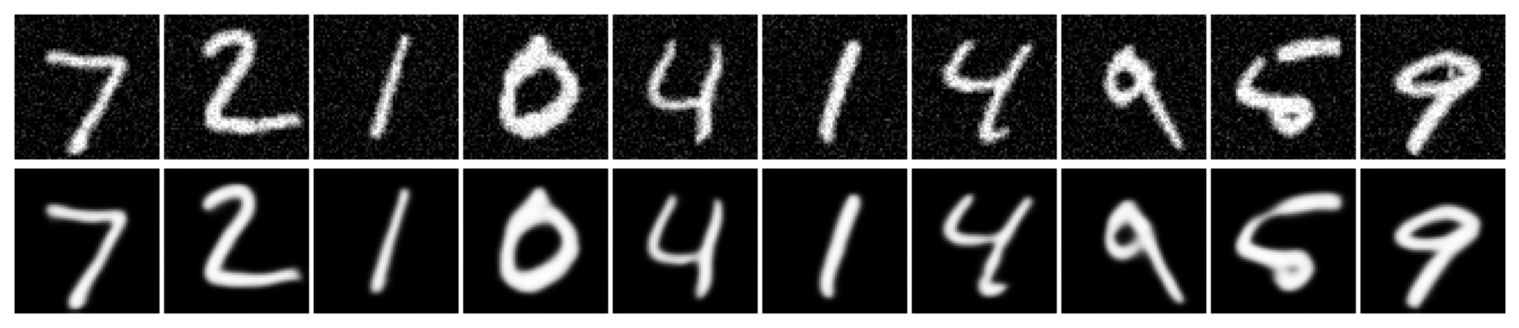

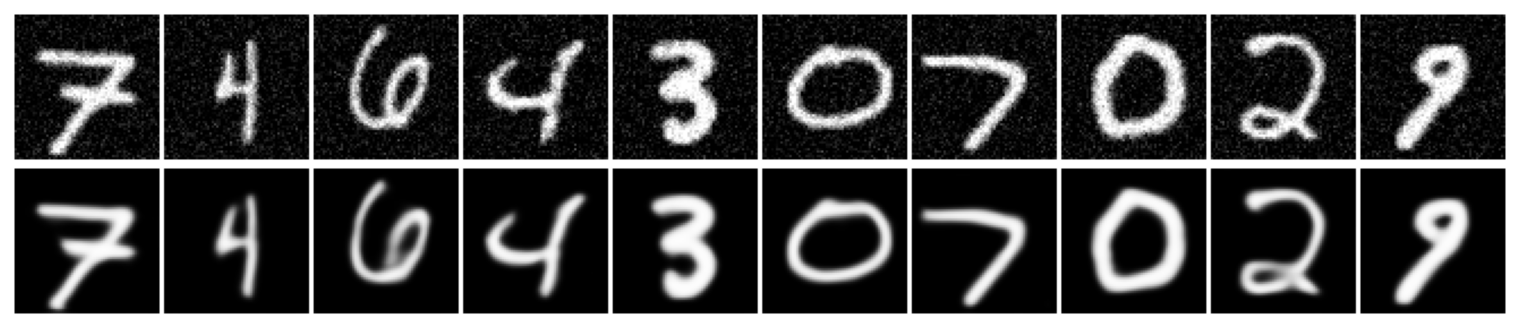

----------------------------------------------------------------------------------------------------


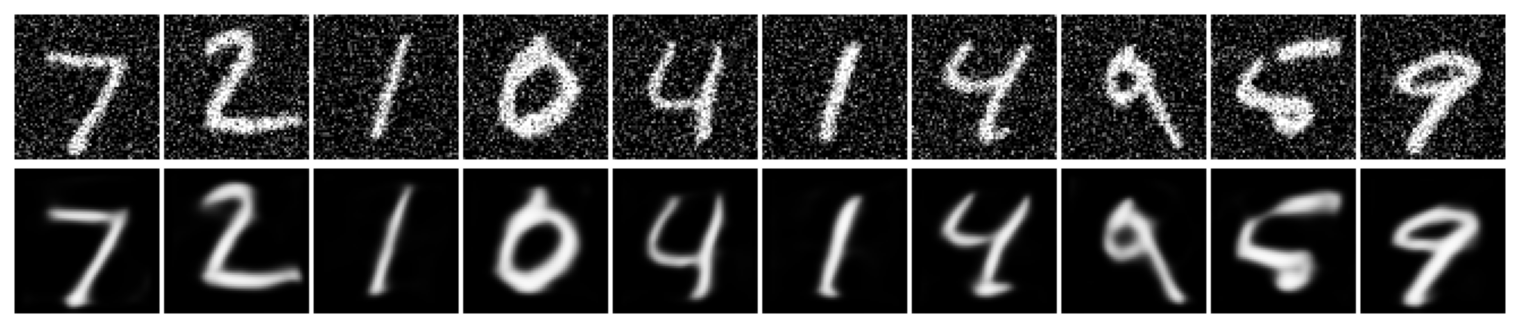

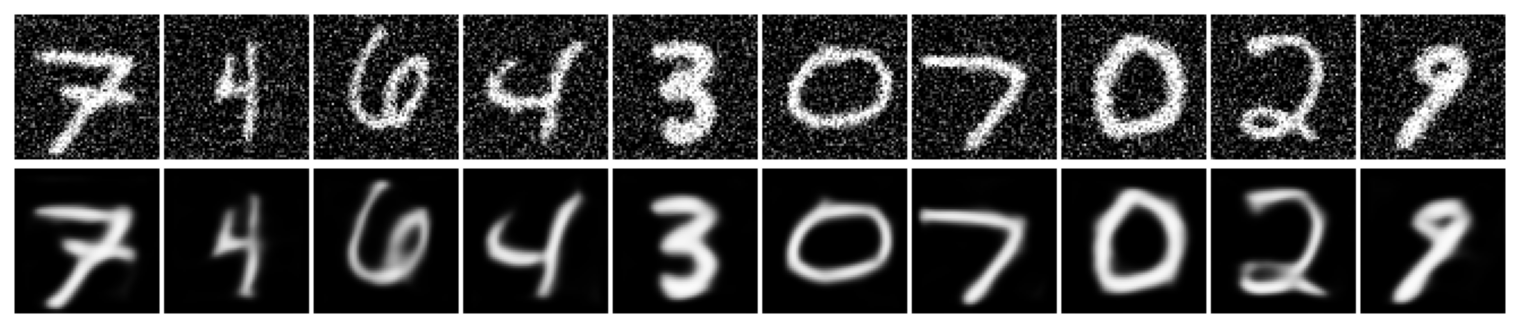

----------------------------------------------------------------------------------------------------


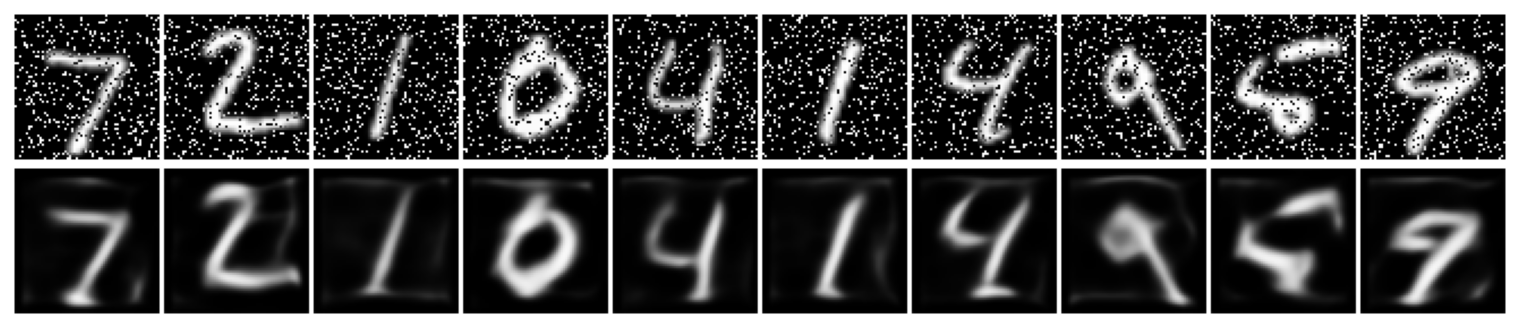

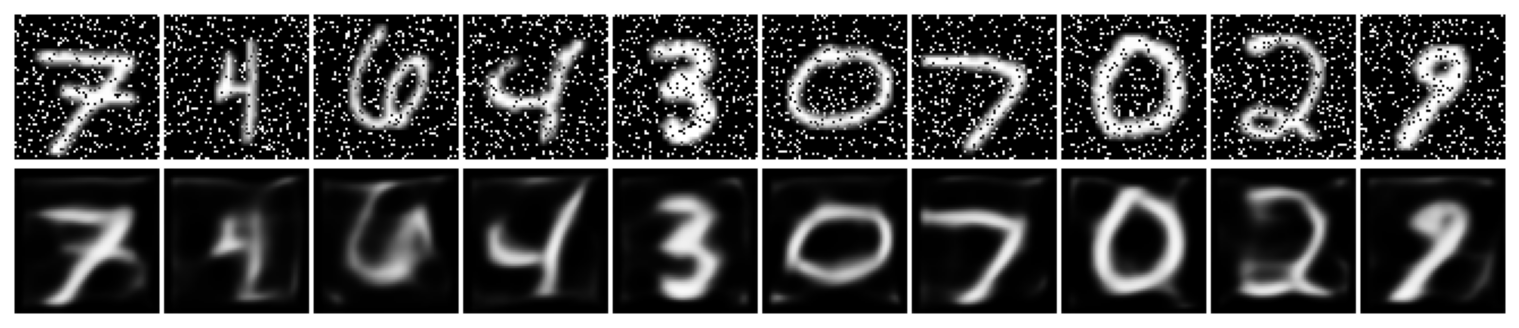

In [46]:
test_denoising(de_model)

In [47]:
@torch.inference_mode()
def get_latent_labels(model, loader, count: int=None): #generating embeddings for a portion of images
    model.eval()
    total = 0
    latent = []
    labels = []
    
    for x, y in loader:
        z = model.encode(x.to(device)).cpu()
        latent.append(z)
        labels.append(y)
        total += y.shape[0]
        if count is not None and total >= count:
            break
            
    latent = torch.cat(latent)[:count].numpy()
    labels = torch.cat(labels)[:count].numpy()
    
    return latent, labels

In [48]:
x, y = get_latent_labels(de_model, train_loader, 1000)

In [49]:
x.shape, y.shape

((1000, 512), (1000,))

In [50]:
clf = RandomForestClassifier().fit(x, y)

In [51]:
x_valid, y_valid = get_latent_labels(de_model, valid_loader)

In [52]:
(clf.predict(x_valid) == y_valid).mean()

0.9221